# T2A-LoRA

## Imports

In [1]:
import os

from transformers import ClapModel, ClapProcessor
from peft import LoraConfig, TaskType, get_peft_model

from config import DatasetConfig
from libritts import LIBRITTSP

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchaudio
import torchaudio.transforms as T

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import Audio
from librosa import display as rosa_display

### Check GPU Availability

In [2]:
!nvidia-smi

Fri Dec 19 11:21:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX PRO 5000 Blac...    On  |   00000000:01:00.0 Off |                  Off |
| 30%   27C    P8             12W /  300W |      18MiB /  48935MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Set CUDA Device Number
DEVICE_NUM = 0

if torch.cuda.is_available():
    device = torch.device(f"cuda:{DEVICE_NUM}")
else:
    device = torch.device("cpu")
    DEVICE_NUM = -1

print(f"INFO: Using device - {device}")

INFO: Using device - cuda:0


## Datasets

In [4]:
def show_waveform(audio_path: str | None, waveform: torch.Tensor | None = None, sr: int = 48000):
    if audio_path:
        waveform, sr = torchaudio.load(audio_path)
    elif waveform is not None:
        waveform = waveform.unsqueeze(0) if len(waveform.shape) == 1 else waveform
    else:
        raise ValueError("Either audio_path or waveform must be provided.")

    plt.figure(figsize=(10, 4))
    rosa_display.waveshow(waveform.numpy()[0], sr=sr)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

    return Audio(waveform.numpy()[0], rate=sr)

In [5]:
datasets = LIBRITTSP(config=DatasetConfig(name="libritts", sample_rate=24000))

INFO: Loading 'test.other' split of LibriTTS dataset...


Resolving data files:   0%|          | 0/63 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/116 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/63 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/116 [00:00<?, ?it/s]

Loaded LibriTTS 'test.other' split with 4705 samples


In [6]:
sample = datasets[0]

'Margaret!' said mr Hale, as he returned from showing his guest downstairs; 'I could not help watching your face with some anxiety, when mr Thornton made his confession of having been a shop boy.
['A gentleman with a high-pitched voice speaks with normal energy and normal speaking speed', 'A high-pitched man speaks with standard speed and normal volume', 'A man with a high-pitched voice speaks at a standard speed and normal volume', 'A man with a high-pitched voice speaks with normal energy and normal speaking speed', 'A man with a high-pitched voice speaks with normal energy and normal volume', 'A man with a high-pitched voice speaks with normal energy and normal volume at a standard speed', 'A man with a high-pitched voice speaks with normal energy and standard speaking speed', 'A man with a high-pitched voice speaks with normal energy and standard speed at normal volume', 'A man with a high-pitched voice speaks with normal speed and average volume', 'A man with a high-pitched voice 

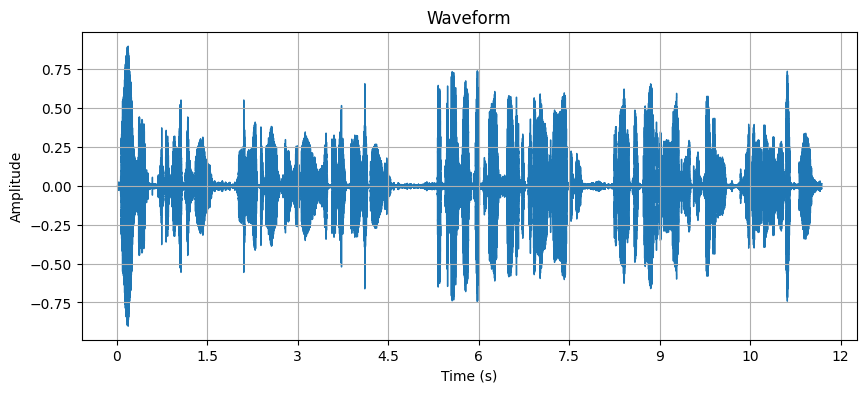

In [7]:
print(sample['content_prompt'])
print(sample['style_prompt'])
show_waveform(None, sample['audio'], sr=sample['sampling_rate'])

## Models

In [8]:
from parler_tts import ParlerTTSForConditionalGeneration
from transformers import AutoTokenizer

Flash attention 2 is not installed


In [9]:
base_model_id = "parler-tts/parler-tts-mini-v1"
clap_model_id = "laion/larger_clap_general"  # "microsoft/msclap"

In [10]:
# Check base model architecture
base_tokenizer = AutoTokenizer.from_pretrained(base_model_id)
base_model = ParlerTTSForConditionalGeneration.from_pretrained(base_model_id)
base_model.to(device)

ValueError: Config has to be initialized with text_encoder, audio_encoder and decoder config

In [ ]:
for param in base_model.parameters():
    param.requires_grad = False

In [ ]:
clap_processor = ClapProcessor.from_pretrained(clap_model_id)

In [ ]:
# Check clap model architecture
clap_model = ClapModel.from_pretrained(clap_model_id)

In [ ]:
for param in clap_model.parameters():
    param.requires_grad = False

In [ ]:
clap_model.text_model.to(device)

## LoRA

In [ ]:
print("\n=== Model Structure ===")
for name, module in base_model.named_modules():
    if isinstance(module, nn.Linear) and 'decoder' in name:
        print(f"{name}: {module}")

In [ ]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=[
        "self_attn.q_proj",
        "self_attn.k_proj",
        "self_attn.v_proj",
        "self_attn.out_proj",
        "fc1",
        "fc2"
    ],
)

print("LoRA config created successfully")

In [ ]:
peft_model = get_peft_model(base_model, lora_config)
peft_model.print_trainable_parameters()

print("\nINFO: LoRA applied successfully!")

## Hypernetwork

In [ ]:
class HyperNetwork(nn.Module):
    """HyperNetwork that generates LoRA weights from CLAP embeddings"""
    
    def __init__(self, clap_dim=512, hidden_dim=1024, lora_params_dict=None):
        super().__init__()
        self.clap_dim = clap_dim
        self.hidden_dim = hidden_dim
        self.lora_params_dict = lora_params_dict or {}
        
        # Shared embedding processor
        self.embedding_processor = nn.Sequential(
            nn.Linear(clap_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
        )
        
        # Create generators for each LoRA parameter
        self.weight_generators = nn.ModuleDict()
        
        for param_name, shape in self.lora_params_dict.items():
            total_elements = shape.numel()
            
            self.weight_generators[param_name.replace('.', '_')] = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.GELU(),
                nn.Dropout(0.1),
                nn.Linear(hidden_dim // 2, total_elements),
            )
    
    def forward(self, clap_embedding):
        """
        Args:
            clap_embedding: (batch_size, clap_dim)
        Returns:
            dict of LoRA weights
        """
        # Process CLAP embedding
        h = self.embedding_processor(clap_embedding)  # (batch_size, hidden_dim)
        
        # Generate LoRA weights
        lora_weights = {}
        for param_name, shape in self.lora_params_dict.items():
            param_key = param_name.replace('.', '_')
            flat_weights = self.weight_generators[param_key](h)  # (batch_size, total_elements)
            
            # Reshape to original shape
            batch_size = flat_weights.shape[0]
            lora_weights[param_name] = flat_weights.view(batch_size, *shape)
        
        return lora_weights

In [ ]:
# Collect LoRA parameter shapes
lora_params_dict = {}
for name, param in peft_model.named_parameters():
    if 'lora' in name and param.requires_grad:
        lora_params_dict[name] = param.shape
        print(f"{name}: {param.shape}")

print(f"\nTotal LoRA parameters to generate: {len(lora_params_dict)}")

In [ ]:
# Initialize HyperNetwork
clap_embedding_dim = clap_model.config.projection_dim  # Usually 512
hypernetwork = HyperNetwork(
    clap_dim=clap_embedding_dim,
    hidden_dim=1024,
    lora_params_dict=lora_params_dict
).to(device)

print(f"HyperNetwork parameters: {sum(p.numel() for p in hypernetwork.parameters()):,}")

## Total Model

In [ ]:
class MFCCLoss(nn.Module):
    """Loss based on MFCC similarity between generated and target audio"""

    def __init__(self, sample_rate=24000, n_mfcc=40, n_mels=80):
        super().__init__()
        self.sample_rate = sample_rate
        self.n_mfcc = n_mfcc
        
        # MFCC transform
        self.mfcc_transform = T.MFCC(
            sample_rate=sample_rate,
            n_mfcc=n_mfcc,
            melkwargs={
                'n_fft': 1024,
                'hop_length': 256,
                'n_mels': n_mels,
                'center': False
            }
        )
    
    def extract_mfcc(self, waveform):
        """
        Extract MFCC features from waveform
        Args:
            waveform: (batch_size, n_samples) or (batch_size, 1, n_samples)
        Returns:
            mfcc: (batch_size, n_mfcc, time)
        """
        if waveform.dim() == 3 and waveform.shape[1] == 1:
            waveform = waveform.squeeze(1)
        
        mfcc = self.mfcc_transform(waveform)
        return mfcc
    
    def forward(self, generated_audio, target_audio):
        """
        Compute MFCC-based loss
        Args:
            generated_audio: (batch_size, n_samples)
            target_audio: (batch_size, n_samples)
        Returns:
            loss: scalar
        """
        # Extract MFCCs
        gen_mfcc = self.extract_mfcc(generated_audio)  # (B, n_mfcc, T1)
        tgt_mfcc = self.extract_mfcc(target_audio)     # (B, n_mfcc, T2)
        
        # Align temporal dimensions (take minimum length)
        min_time = min(gen_mfcc.shape[-1], tgt_mfcc.shape[-1])
        gen_mfcc = gen_mfcc[..., :min_time]
        tgt_mfcc = tgt_mfcc[..., :min_time]
        
        # Compute L1 loss (better for audio than L2)
        mfcc_loss = F.l1_loss(gen_mfcc, tgt_mfcc)
        
        # Optional: Add cosine similarity loss for phase alignment
        gen_flat = gen_mfcc.flatten(1)  # (B, n_mfcc*T)
        tgt_flat = tgt_mfcc.flatten(1)
        cosine_sim = F.cosine_similarity(gen_flat, tgt_flat, dim=1).mean()
        cosine_loss = 1 - cosine_sim
        
        # Combined loss
        total_loss = mfcc_loss + 0.1 * cosine_loss
        
        return total_loss, {
            'mfcc_l1': mfcc_loss.item(),
            'cosine_loss': cosine_loss.item(),
            'total': total_loss.item()
        }

In [ ]:
mfcc_loss_fn = MFCCLoss(sample_rate=24000).to(device)

In [ ]:
class T2ALoRAModel(nn.Module):
    """Complete Text-to-Audio LoRA model with MFCC-based training"""
    
    def __init__(self, clap_model, clap_processor, hypernetwork, peft_model, base_tokenizer):
        super().__init__()
        self.clap_model = clap_model
        self.clap_processor = clap_processor
        self.hypernetwork = hypernetwork
        self.peft_model = peft_model
        self.base_tokenizer = base_tokenizer
        self.device = torch.device("cpu")
        
        # Freeze CLAP and base Parler-TTS
        for param in self.clap_model.parameters():
            param.requires_grad = False
        for name, param in self.peft_model.named_parameters():
            if 'lora' not in name:
                param.requires_grad = False

    def to(self, *args, **kwargs):
        super().to(*args, **kwargs)
        for arg in args:
            if isinstance(arg, torch.device):
                self.device = arg
        for kwarg in kwargs.values():
            if isinstance(kwarg, torch.device):
                self.device = arg

    def get_clap_embeddings(self, text_descriptions):
        """Get CLAP text embeddings for voice descriptions"""
        # text_descriptions가 리스트면 첫 번째 요소만, 문자열이면 그대로 사용
        if isinstance(text_descriptions, list):
            text = text_descriptions[0] if text_descriptions else ""
        else:
            text = text_descriptions
        
        # 단일 문자열로 처리
        inputs = self.clap_processor(
            text=text,  # 리스트가 아닌 문자열로 전달
            return_tensors="pt",
            padding=True,
            truncation=True
        )
        
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            text_embeds = self.clap_model.get_text_features(**inputs)
        
        return text_embeds
    
    def apply_lora_weights(self, lora_weights, batch_idx=0):
        """Apply generated LoRA weights to the model"""
        with torch.no_grad():
            for name, param in self.peft_model.named_parameters():
                if 'lora' in name and param.requires_grad:
                    if name in lora_weights:
                        # Use weights for this batch sample
                        generated_weight = lora_weights[name][batch_idx]
                        param.copy_(generated_weight)
    
    def generate_audio(self, input_texts, voice_descriptions):
        """
        Generate audio with dynamic LoRA weights
        Args:
            input_texts: list of strings
            voice_descriptions: list of strings
        Returns:
            generated_audios: list of tensors
        """
        # Get CLAP embeddings
        clap_embeds = self.get_clap_embeddings(voice_descriptions)
        
        # Generate LoRA weights
        lora_weights = self.hypernetwork(clap_embeds)
        
        # Tokenize input texts
        inputs = self.base_tokenizer(
            input_texts,
            return_tensors="pt",
            padding=True,
            truncation=True
        ).to(self.peft_model.device)
        
        # Generate audio for each sample in batch
        generated_audios = []
        batch_size = len(input_texts)
        
        for i in range(batch_size):
            # Apply LoRA weights for this sample
            self.apply_lora_weights(lora_weights, batch_idx=i)
            
            # Generate audio
            with torch.no_grad():
                generation = self.peft_model.generate(
                    input_ids=inputs.input_ids[i:i+1],
                    attention_mask=inputs.attention_mask[i:i+1],
                    # Empty prompt - we don't use Parler's text styling
                    prompt_input_ids=None,
                    prompt_attention_mask=None,
                    do_sample=True,
                    temperature=1.0,
                    max_length=2000,
                )
            
            # Decode to audio
            audio_arr = self.peft_model.audio_encoder.decode(
                generation,
                audio_scales=[None]
            )
            audio = torch.from_numpy(audio_arr).squeeze(0)
            generated_audios.append(audio)
        
        return generated_audios, lora_weights
    
    def forward(self, voice_descriptions, input_texts, target_audios=None):
        """
        Forward pass with MFCC-based loss
        Args:
            voice_descriptions: list of strings describing voice style
            input_texts: list of strings to synthesize
            target_audios: (batch_size, n_samples) target audio waveforms
        Returns:
            dict with loss and generated audios
        """
        # Generate audio
        generated_audios, lora_weights = self.generate_audio(input_texts, voice_descriptions)
        
        # If training, compute loss
        if target_audios is not None and self.training:
            # Stack generated audios
            # Need to pad/trim to same length
            max_len = max(audio.shape[-1] for audio in generated_audios)
            padded_gen = []
            for audio in generated_audios:
                if audio.shape[-1] < max_len:
                    padding = max_len - audio.shape[-1]
                    audio = F.pad(audio, (0, padding))
                else:
                    audio = audio[..., :max_len]
                padded_gen.append(audio)
            
            gen_batch = torch.stack(padded_gen).to(target_audios.device)
            
            # Align target audio length
            if target_audios.shape[-1] != max_len:
                if target_audios.shape[-1] < max_len:
                    padding = max_len - target_audios.shape[-1]
                    target_audios = F.pad(target_audios, (0, padding))
                else:
                    target_audios = target_audios[..., :max_len]
            
            # Compute MFCC loss
            loss, loss_dict = mfcc_loss_fn(gen_batch, target_audios)
            
            return {
                'loss': loss,
                'loss_dict': loss_dict,
                'generated_audios': generated_audios,
                'lora_weights': lora_weights
            }
        else:
            return {
                'generated_audios': generated_audios,
                'lora_weights': lora_weights
            }

In [ ]:
voice_model = T2ALoRAModel(clap_model, clap_processor, hypernetwork, peft_model, base_tokenizer)
voice_model.to(device)

## Training

In [ ]:
# Training hyperparameters
BATCH_SIZE = 2  # Reduced due to audio generation overhead
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
WARMUP_STEPS = 500
SAVE_STEPS = 500
LOG_STEPS = 50
OUTPUT_DIR = "./t2a_lora_mfcc_checkpoints"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
# Create DataLoader
train_dataloader = DataLoader(
    datasets,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda x: x
)

print(f"Total training batches: {len(train_dataloader)}")

In [ ]:
# Optimizer - only train hypernetwork
optimizer = AdamW(
    hypernetwork.parameters(),
    lr=LEARNING_RATE,
    weight_decay=0.01
)

# Learning rate scheduler
total_steps = len(train_dataloader) * NUM_EPOCHS
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=total_steps,
    eta_min=1e-6
)

print(f"Optimizer configured: {sum(p.numel() for p in hypernetwork.parameters()):,} trainable parameters")

In [ ]:
DUMMY = "A female speaker delivers a slightly expressive and animated speech with a moderate speed and pitch. The recording is of very high quality, with the speaker's voice sounding clear and very close up."

In [ ]:
# Training loop with MFCC-based loss
global_step = 0
best_loss = float('inf')

print("Starting MFCC-based training...\n")
print("Strategy: Compare generated audio vs target audio using MFCC features")
print("Goal: LoRA learns to modify voice style while preserving content\n")

for epoch in range(NUM_EPOCHS):
    voice_model.train()
    epoch_loss = 0
    epoch_mfcc_l1 = 0
    epoch_cosine = 0
    
    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    for batch_idx, batch in enumerate(pbar):
        batch_loss = 0
        batch_mfcc_l1 = 0
        batch_cosine = 0
        
        # Process each sample individually (no batching for generation)
        for item in batch:
            voice_description = item['style_prompt']
            input_text = item['content_prompt']
            target_audio = item['audio'].to(device)
            
            # Ensure target is 1D
            if target_audio.dim() > 1:
                target_audio = target_audio.squeeze()
            
            # Get CLAP embeddings
            clap_embeds = voice_model.get_clap_embeddings([voice_description])
            
            # Generate LoRA weights
            lora_weights = hypernetwork(clap_embeds)
            
            # Apply LoRA weights (single sample)
            voice_model.apply_lora_weights(lora_weights, batch_idx=0)
            
            # Tokenize input text
            inputs = base_tokenizer(
                [input_text],
                return_tensors="pt",
                padding=True,
                truncation=True
            ).to(device)
            style_inputs = base_tokenizer(DUMMY, return_tensors="pt", padding=True).to(device)

            # Generate audio
            generation = peft_model.generate(
                input_ids=inputs.input_ids,
                attention_mask=inputs.attention_mask,
                prompt_input_ids=style_inputs.input_ids,
                prompt_attention_mask=style_inputs.attention_mask,
                do_sample=True,
                temperature=1.0,
                max_length=2000,
            )
            
            # Decode to audio
            audio_arr = generation.squeeze().cpu().numpy()
            generated_audio = torch.from_numpy(audio_arr).squeeze().to(device)
            
            # Align lengths for MFCC comparison
            min_len = min(generated_audio.shape[-1], target_audio.shape[-1])
            gen_audio_aligned = generated_audio[..., :min_len]
            tgt_audio_aligned = target_audio[..., :min_len]
            
            # Add batch dimension for loss function
            gen_batch = gen_audio_aligned.unsqueeze(0)
            tgt_batch = tgt_audio_aligned.unsqueeze(0)
            
            # Compute MFCC loss
            loss, loss_dict = mfcc_loss_fn(gen_batch, tgt_batch)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            nn.utils.clip_grad_norm_(hypernetwork.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Accumulate losses
            batch_loss += loss.item()
            batch_mfcc_l1 += loss_dict['mfcc_l1']
            batch_cosine += loss_dict['cosine_loss']
        
        # Average losses over batch
        if len(batch) > 0:
            batch_loss /= len(batch)
            batch_mfcc_l1 /= len(batch)
            batch_cosine /= len(batch)
            
            epoch_loss += batch_loss
            epoch_mfcc_l1 += batch_mfcc_l1
            epoch_cosine += batch_cosine
            
            scheduler.step()
            global_step += 1
            
            pbar.set_postfix({
                'loss': f"{batch_loss:.4f}",
                'mfcc_l1': f"{batch_mfcc_l1:.4f}",
                'cosine': f"{batch_cosine:.4f}",
                'lr': f"{scheduler.get_last_lr()[0]:.2e}"
            })
            
            # Periodic logging
            if global_step % LOG_STEPS == 0:
                avg_loss = epoch_loss / (batch_idx + 1)
                avg_mfcc = epoch_mfcc_l1 / (batch_idx + 1)
                avg_cosine = epoch_cosine / (batch_idx + 1)
                print(f"\nStep {global_step}:")
                print(f"  Avg Total Loss: {avg_loss:.4f}")
                print(f"  Avg MFCC L1: {avg_mfcc:.4f}")
                print(f"  Avg Cosine: {avg_cosine:.4f}")
            
            # Save checkpoint
            if global_step % SAVE_STEPS == 0:
                checkpoint_path = os.path.join(OUTPUT_DIR, f"checkpoint-{global_step}")
                os.makedirs(checkpoint_path, exist_ok=True)
                
                torch.save({
                    'epoch': epoch,
                    'global_step': global_step,
                    'hypernetwork_state_dict': hypernetwork.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'avg_loss': avg_loss,
                }, os.path.join(checkpoint_path, 'model.pt'))
                
                print(f"\nCheckpoint saved at step {global_step}")
    
    # End of epoch
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    avg_epoch_mfcc = epoch_mfcc_l1 / len(train_dataloader)
    avg_epoch_cosine = epoch_cosine / len(train_dataloader)
    
    print(f"\nEpoch {epoch+1} completed:")
    print(f"  Average Total Loss: {avg_epoch_loss:.4f}")
    print(f"  Average MFCC L1: {avg_epoch_mfcc:.4f}")
    print(f"  Average Cosine: {avg_epoch_cosine:.4f}")
    
    # Save best model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        best_model_path = os.path.join(OUTPUT_DIR, "best_model")
        os.makedirs(best_model_path, exist_ok=True)
        
        torch.save({
            'epoch': epoch,
            'hypernetwork_state_dict': hypernetwork.state_dict(),
            'best_loss': best_loss,
        }, os.path.join(best_model_path, 'model.pt'))
        
        print(f"Best model saved with loss: {best_loss:.4f}")

print("\nTraining completed!")

## Test

In [ ]:
# Load best model for inference
def load_best_model():
    best_model_path = os.path.join(OUTPUT_DIR, "best_model", "model.pt")
    checkpoint = torch.load(best_model_path)
    hypernetwork.load_state_dict(checkpoint['hypernetwork_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']} with loss {checkpoint['best_loss']:.4f}")

In [ ]:
# load_best_model()
voice_model.eval()

In [ ]:
# Test inference
test_voice_desc = ["A clear, young female voice with a British accent"]
test_text = ["Hello, this is a test of the dynamic voice adaptation system."]

with torch.no_grad():
    outputs = voice_model(
        voice_descriptions=test_voice_desc,
        input_texts=test_text,
        target_audios=None
    )
    
    generated_audio = outputs['generated_audios'][0]

print("Inference completed successfully!")
print(f"Generated audio shape: {generated_audio.shape}")

# Play generated audio
Audio(generated_audio.cpu().numpy(), rate=24000)

In [ ]:
# Visualize MFCC comparison
def visualize_mfcc_comparison(generated, target, sr=24000):
    """Visualize MFCC features of generated vs target audio"""
    mfcc_transform = T.MFCC(
        sample_rate=sr,
        n_mfcc=40,
        melkwargs={'n_fft': 1024, 'hop_length': 256, 'n_mels': 80}
    )
    
    # Ensure same length
    min_len = min(generated.shape[-1], target.shape[-1])
    gen = generated[..., :min_len]
    tgt = target[..., :min_len]
    
    # Compute MFCCs
    gen_mfcc = mfcc_transform(gen.unsqueeze(0)).squeeze(0).cpu().numpy()
    tgt_mfcc = mfcc_transform(tgt.unsqueeze(0)).squeeze(0).cpu().numpy()
    
    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    im1 = axes[0].imshow(gen_mfcc, aspect='auto', origin='lower', cmap='viridis')
    axes[0].set_title('Generated Audio MFCC')
    axes[0].set_ylabel('MFCC Coefficient')
    plt.colorbar(im1, ax=axes[0])
    
    im2 = axes[1].imshow(tgt_mfcc, aspect='auto', origin='lower', cmap='viridis')
    axes[1].set_title('Target Audio MFCC')
    axes[1].set_ylabel('MFCC Coefficient')
    axes[1].set_xlabel('Time Frame')
    plt.colorbar(im2, ax=axes[1])
    
    plt.tight_layout()
    plt.show()

# Test with a sample
sample = datasets[0]
test_desc = [sample['style_prompt']]
test_txt = [sample['content_prompt']]

with torch.no_grad():
    out = voice_model(
        voice_descriptions=test_desc,
        input_texts=test_txt,
        target_audios=None
    )
    gen_audio = out['generated_audios'][0]

visualize_mfcc_comparison(gen_audio.cpu(), sample['audio'], sr=24000)